<a href="https://colab.research.google.com/github/Anushka03716/DataScience/blob/main/CardioSense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline


In [2]:
from google.colab import files

uploaded = files.upload()


Saving heart.csv to heart.csv
Saving heart-disease-prediction-modern.ipynb to heart-disease-prediction-modern.ipynb


In [3]:
# Set the resolution of the plots
plt.rcParams['figure.dpi'] = 200

# Configure Seaborn plot styles
sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

# Load dataset
df = pd.read_csv("heart.csv")

# Display the first few rows
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  


In [4]:
# Display dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
# Define continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Convert remaining features to object (categorical)
feature_to_convert = [col for col in df.columns if col not in continuous_features]
df[feature_to_convert] = df[feature_to_convert].astype('object')

df.dtypes

,0
age,int64
sex,object
cp,object
trestbps,int64
chol,int64
fbs,object
restecg,object
thalach,int64
exang,object
oldpeak,float64


In [ ]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [ ]:
df.describe(include=['object'])

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


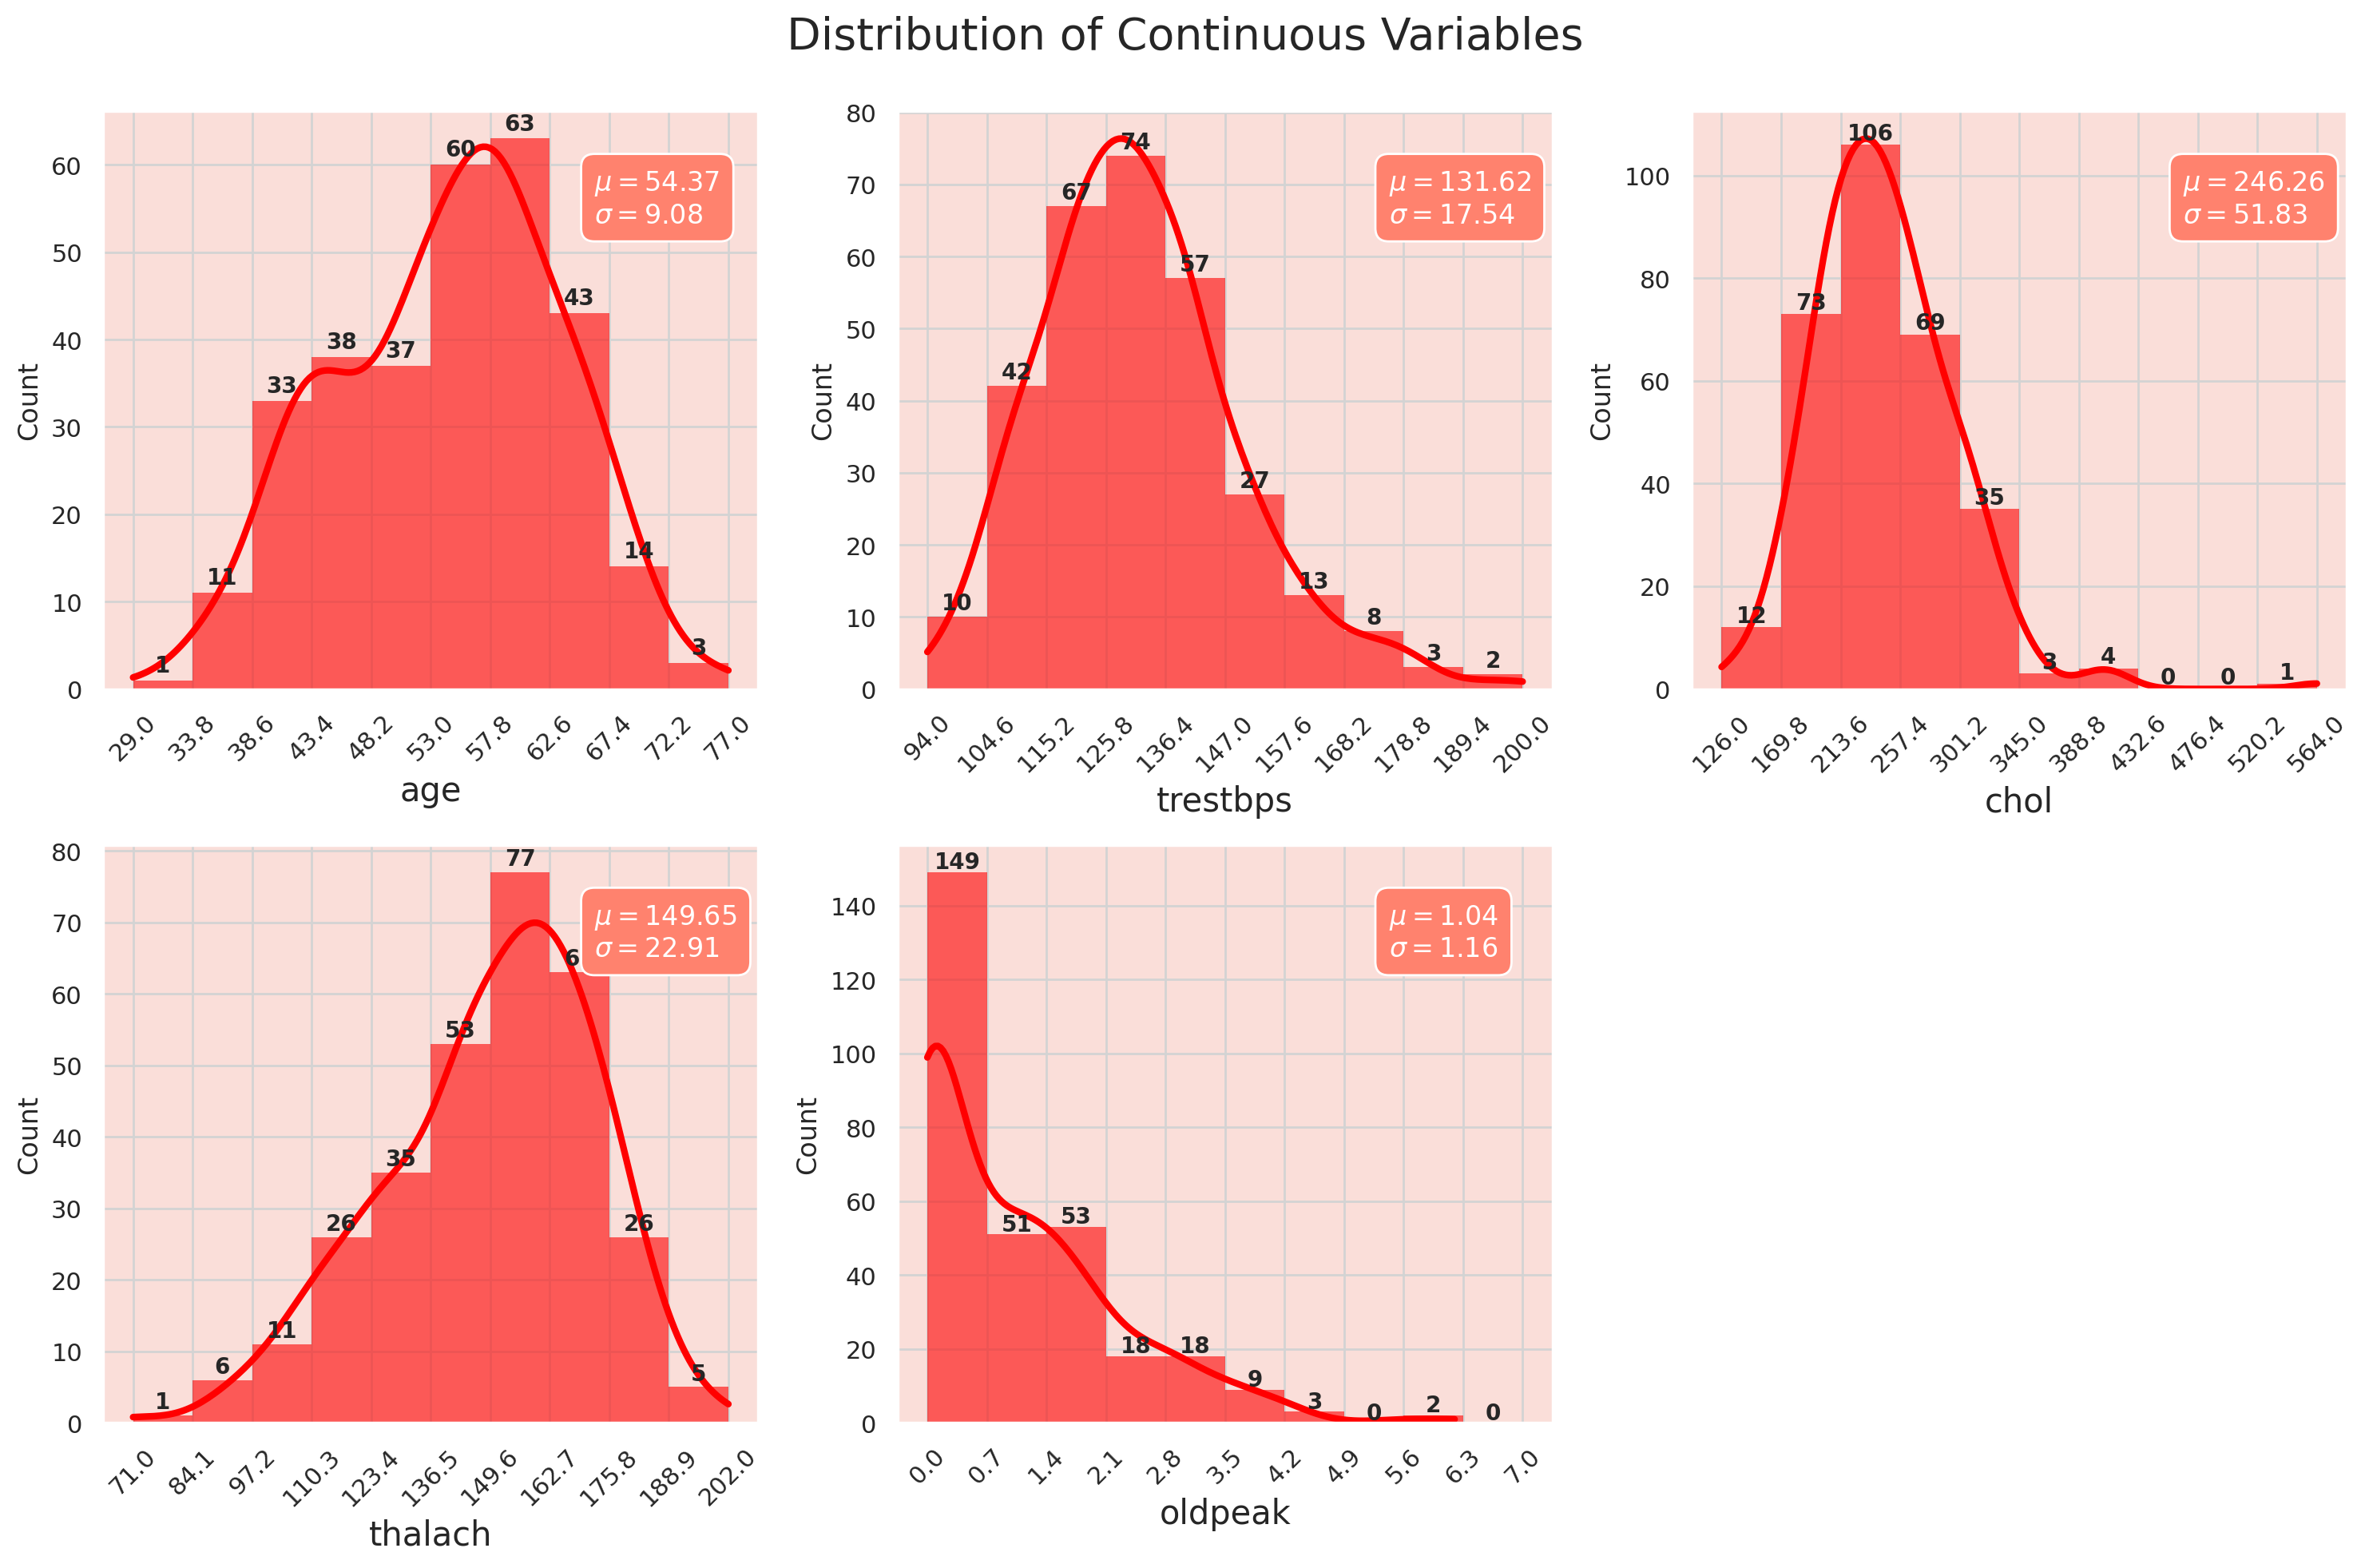

In [ ]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(
        df_continuous[col],
        range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max()))
    )

    graph = sns.histplot(
        data=df_continuous,
        x=col,
        bins=bin_edges,
        kde=True,
        ax=ax[x, y],
        edgecolor='none',
        color='red',
        alpha=0.6,
        line_kws={'lw': 3}
    )

    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')

    for j, p in enumerate(graph.patches):
        ax[x, y].annotate(
            '{}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2, p.get_height() + 1),
            ha='center',
            fontsize=10,
            fontweight='bold'
        )

    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))

    ax[x, y].text(
        0.75, 0.9, textstr,
        transform=ax[x, y].transAxes,
        fontsize=12,
        verticalalignment='top',
        color='white',
        bbox=dict(
            boxstyle='round',
            facecolor='#ff826e',
            edgecolor='white',
            pad=0.5
        )
    )

ax[1, 2].axis('off')

plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [ ]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

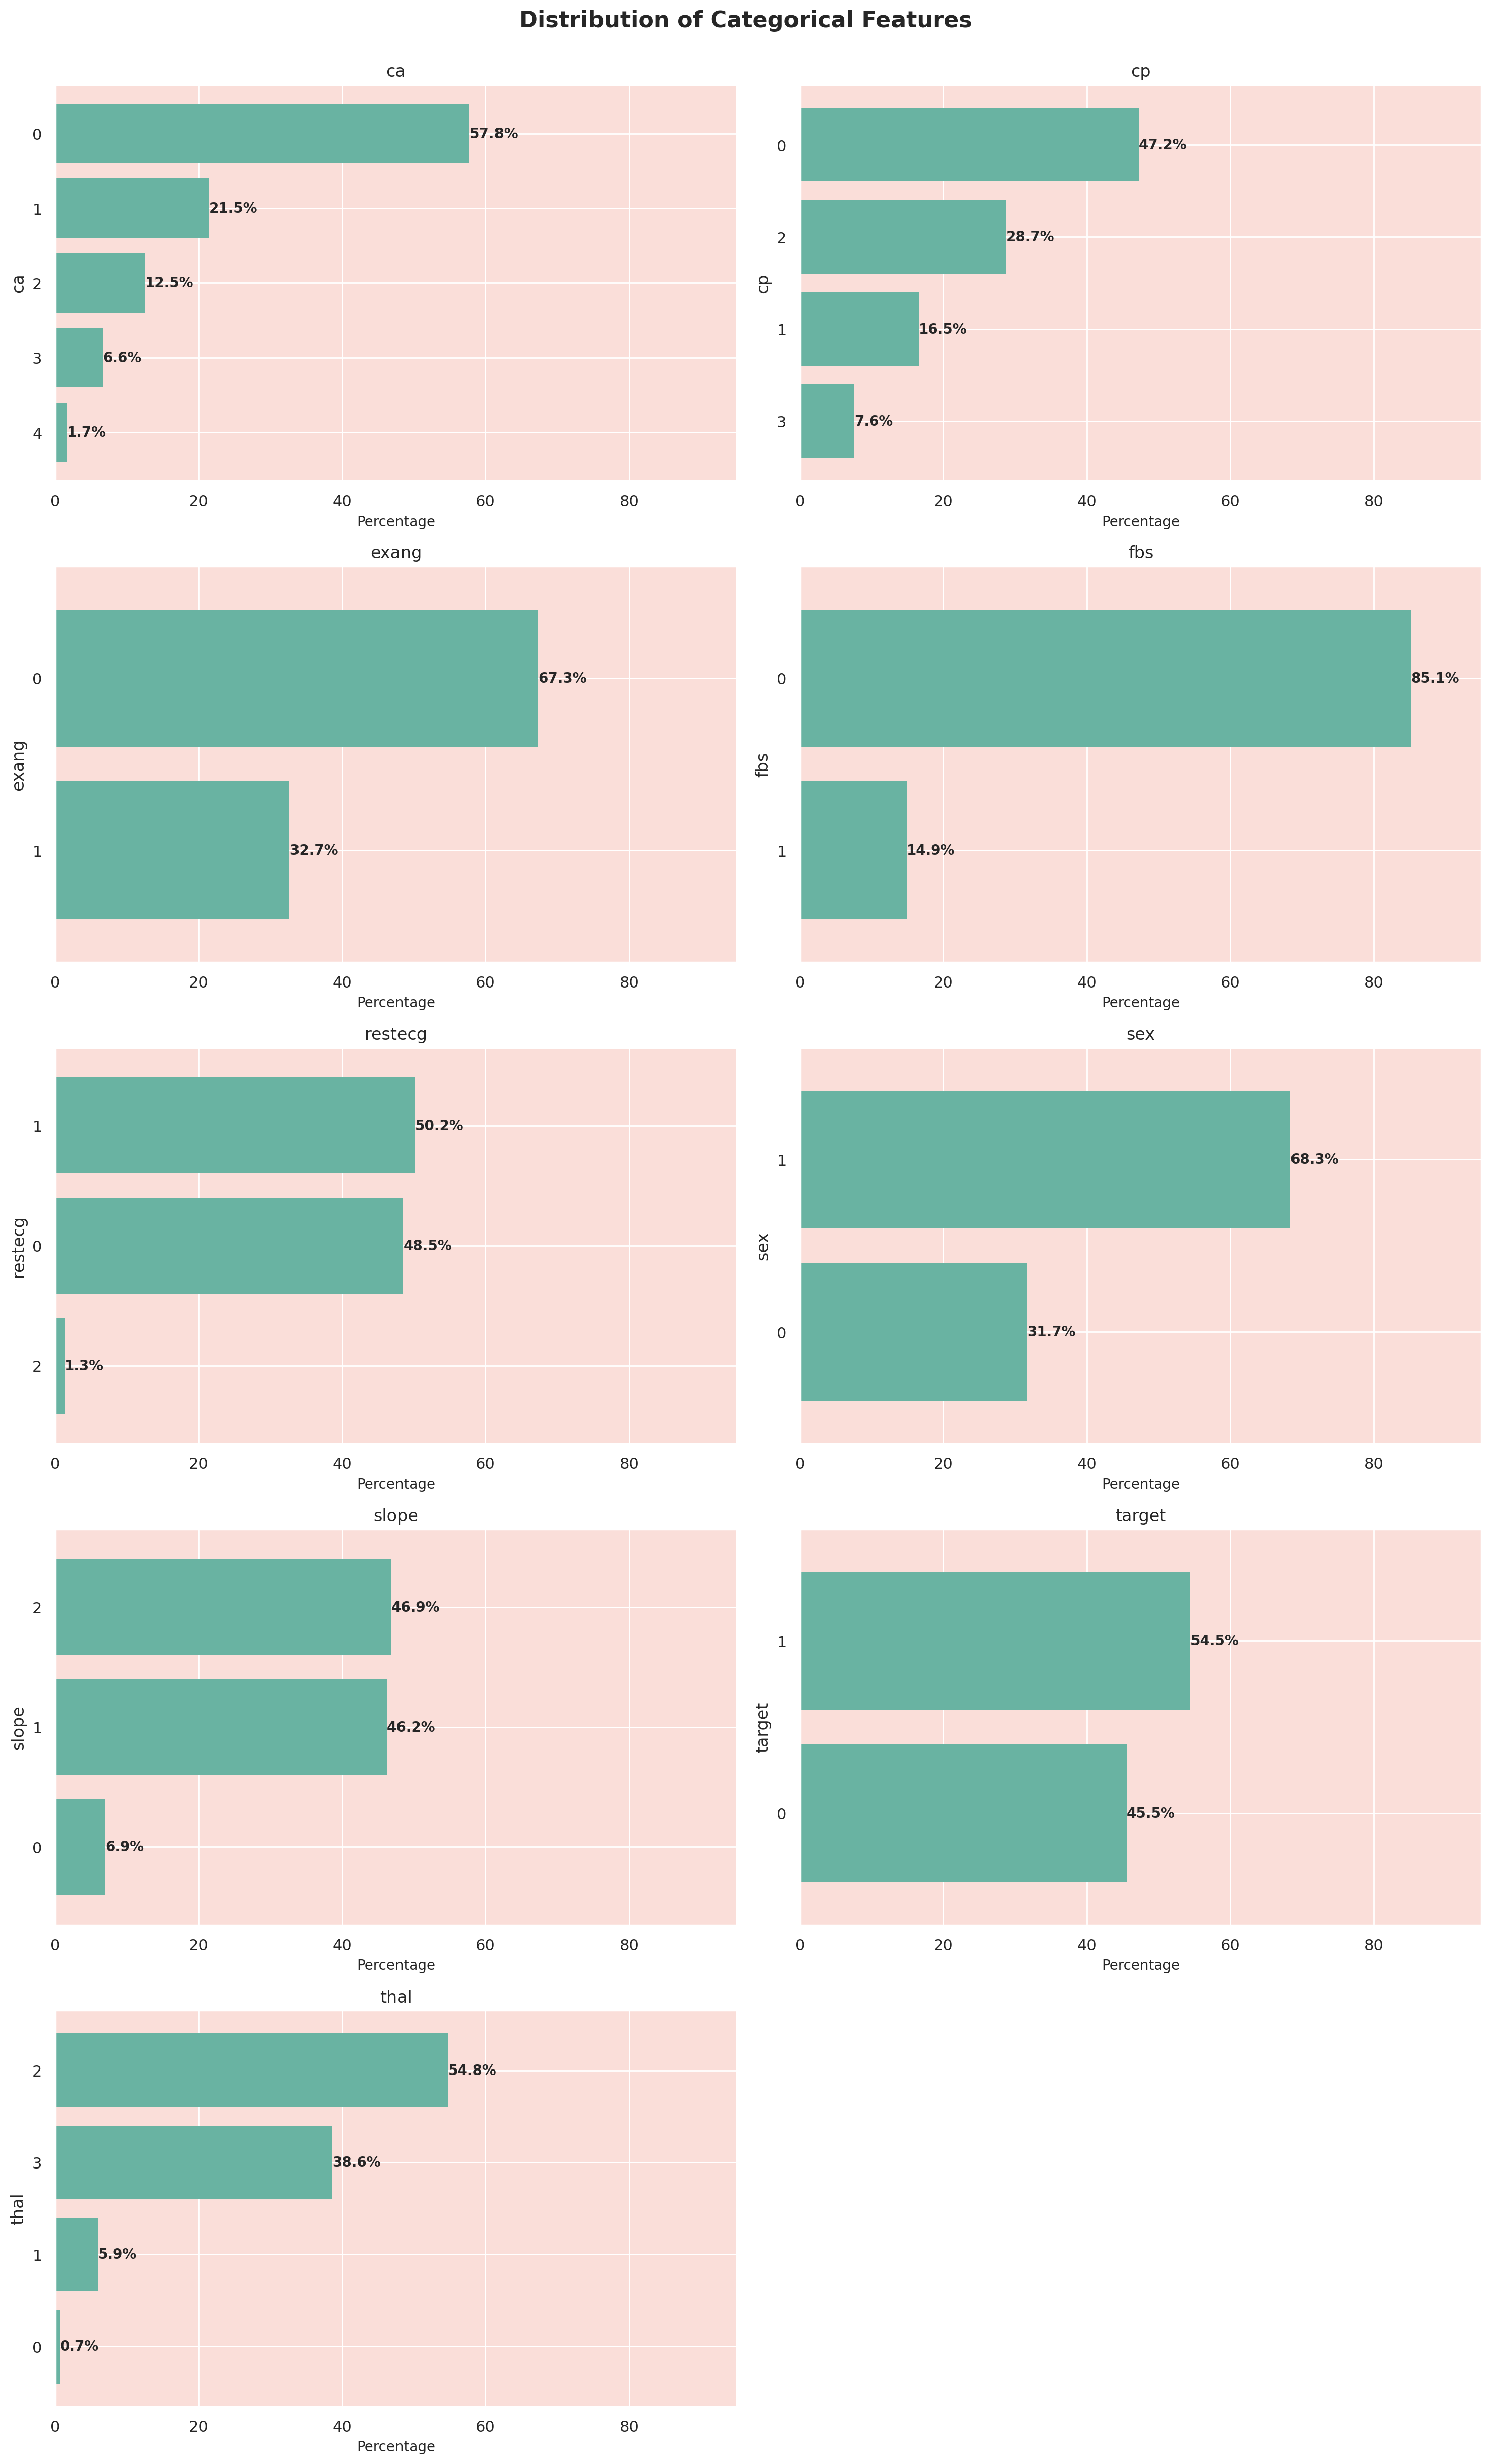

In [ ]:
import math

n_features = len(categorical_features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
ax = ax.flatten()

for i, col in enumerate(categorical_features):

    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()

    value_counts.plot(
        kind='barh',
        ax=ax[i],
        color='#69b3a2',
        edgecolor='none',
        width=0.8
    )

    for index, value in enumerate(value_counts):
        ax[i].text(
            value, index, f"{round(value, 1)}%",
            va='center', fontsize=10, weight='bold'
        )

    ax[i].set_xlim([0, 95])
    ax[i].set_xlabel('Percentage', fontsize=10)
    ax[i].set_title(col, fontsize=12)

# Hide unused axes
for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.suptitle('Distribution of Categorical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()



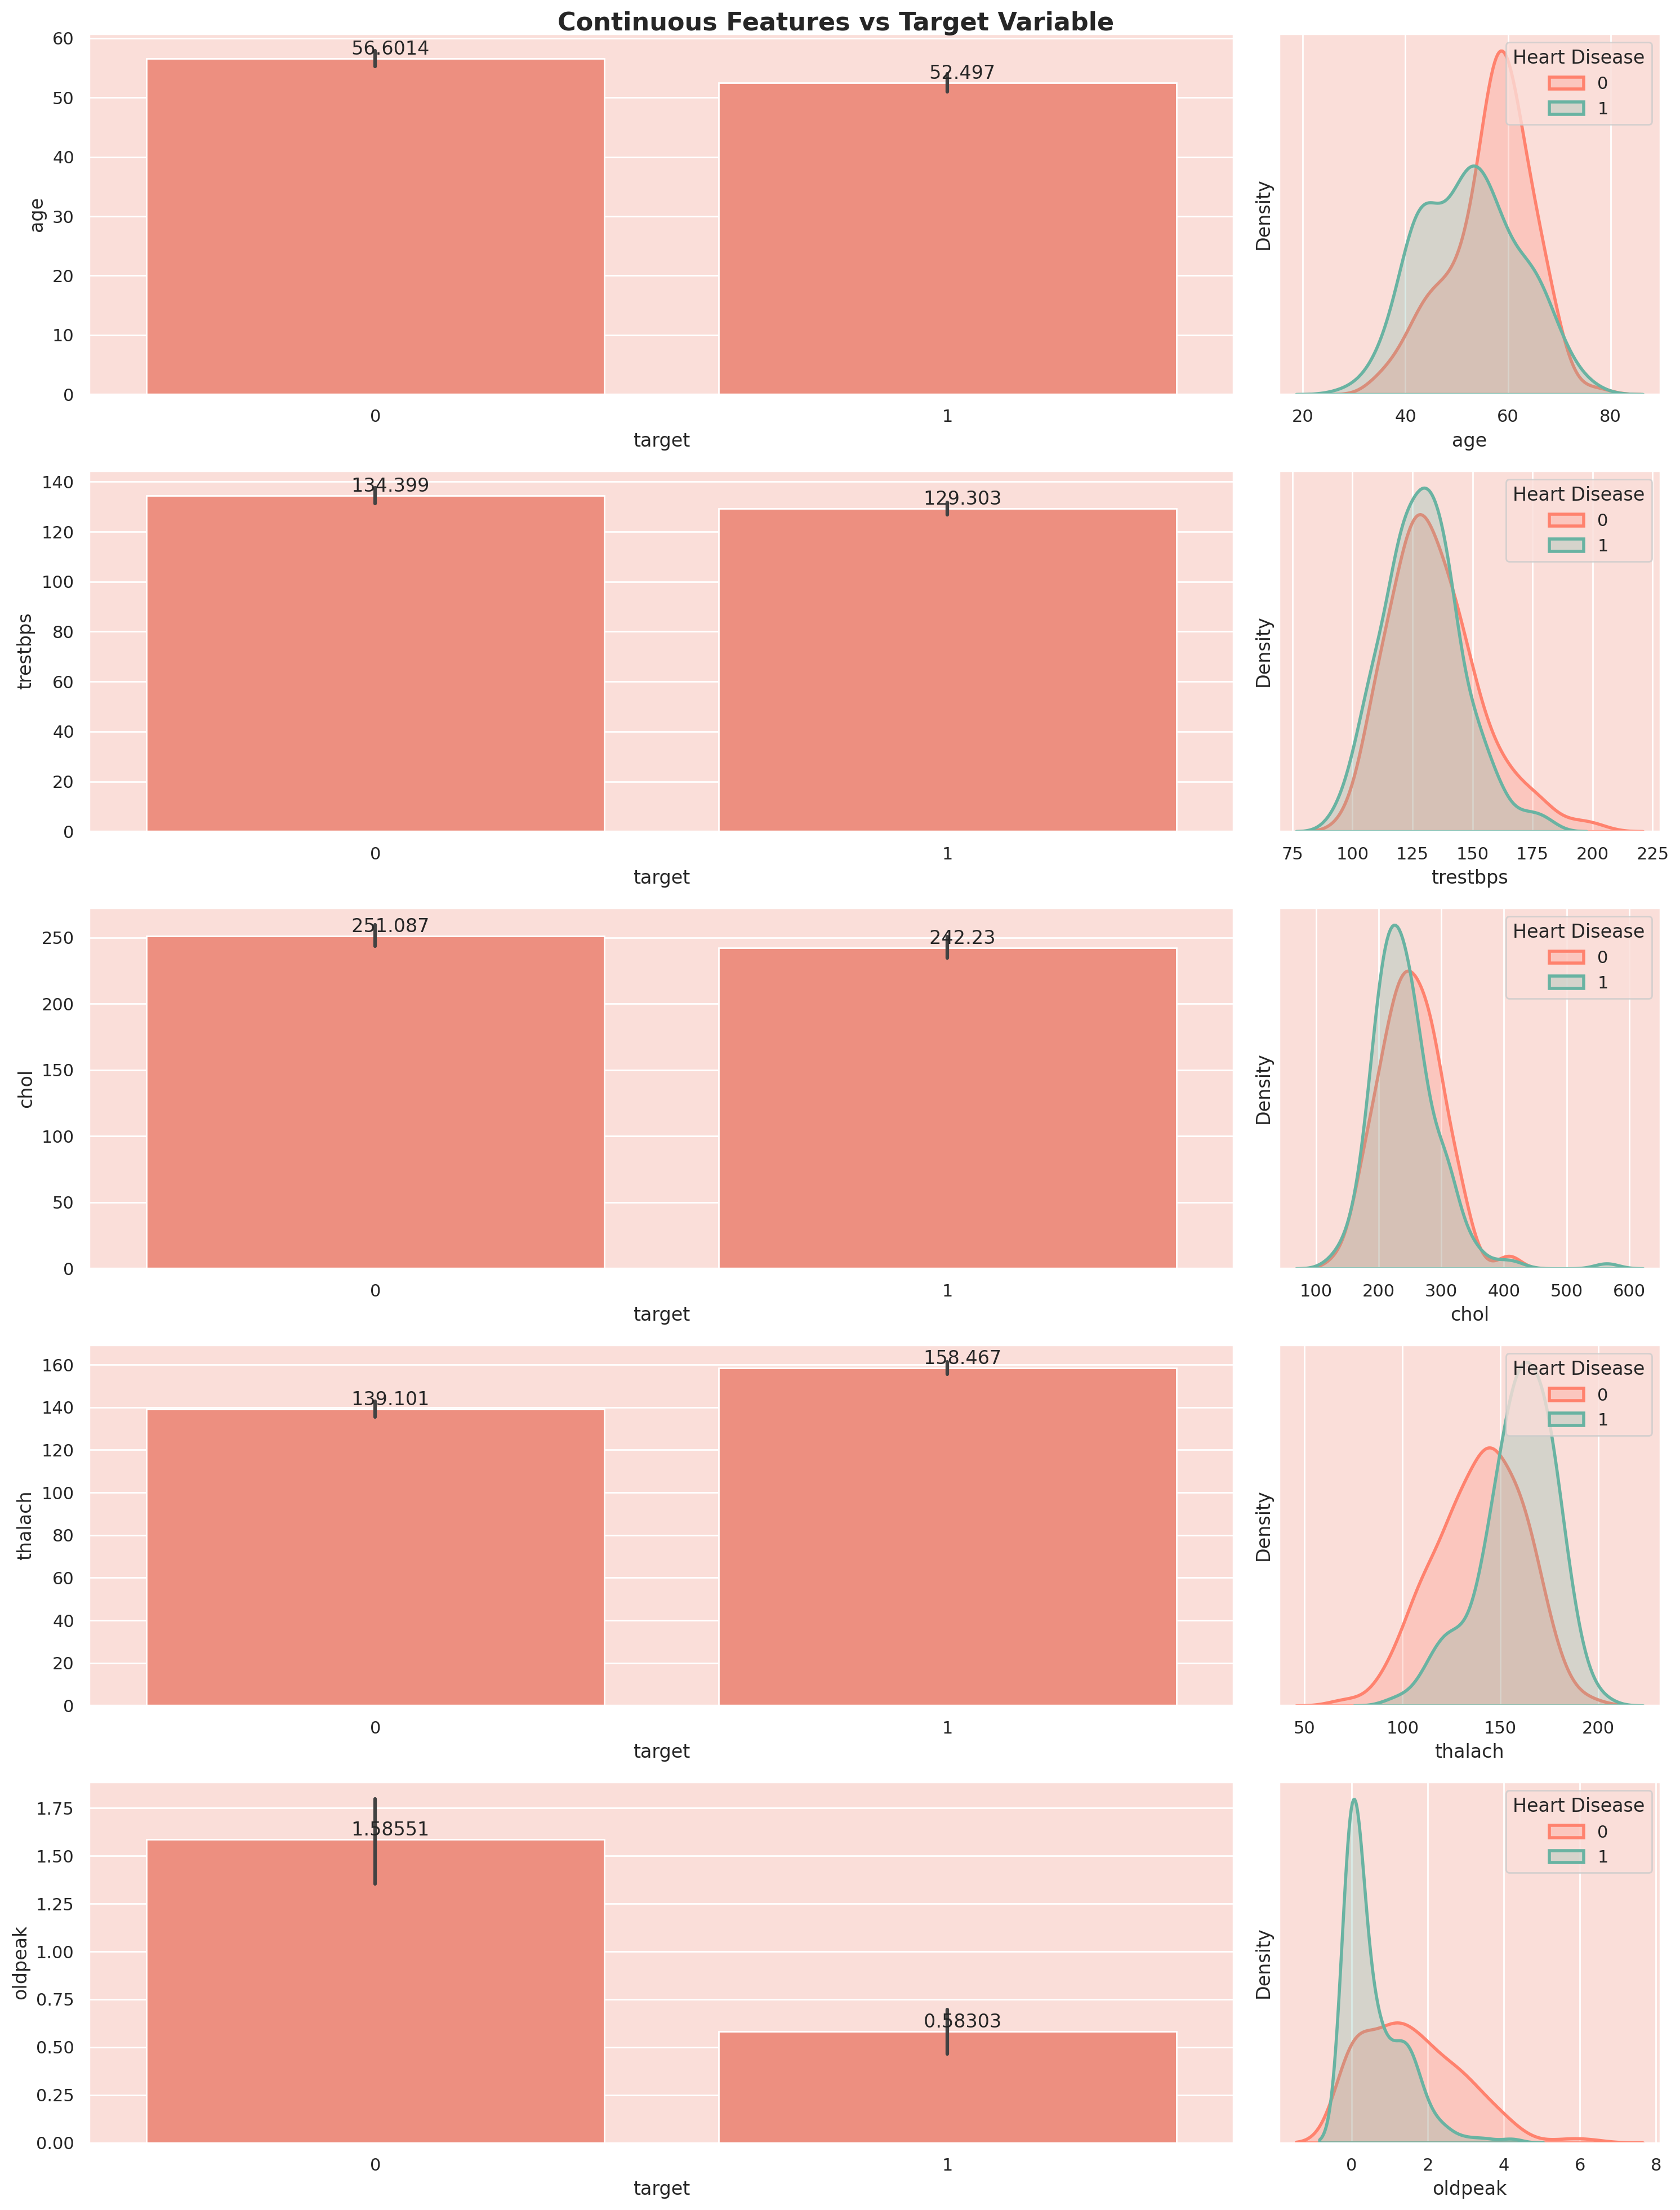

In [ ]:
#Set color palette
sns.set_palette(['#ff826e', '#69b3a2'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15, 20), gridspec_kw={'width_ratios': [3, 1]})

#loop through each continuos features to create barplots and kde plots
for i, col in enumerate(continuous_features):
    #Barplot showing the mean value of the feature for eac target category
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])

    #KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([]) # Changed set_ytricks to set_yticks
    ax[i,1].legend(title='Heart Disease', loc='upper right') # Corrected 'Diease' to 'Disease'

    #Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='     %3g')

# Set titles and labels
plt.suptitle('Continuous Features vs Target Variable', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
#Remove 'target' from the list of categorical features for the count plot
categorical_features = [feature for feature in categorical_features if feature != 'target']

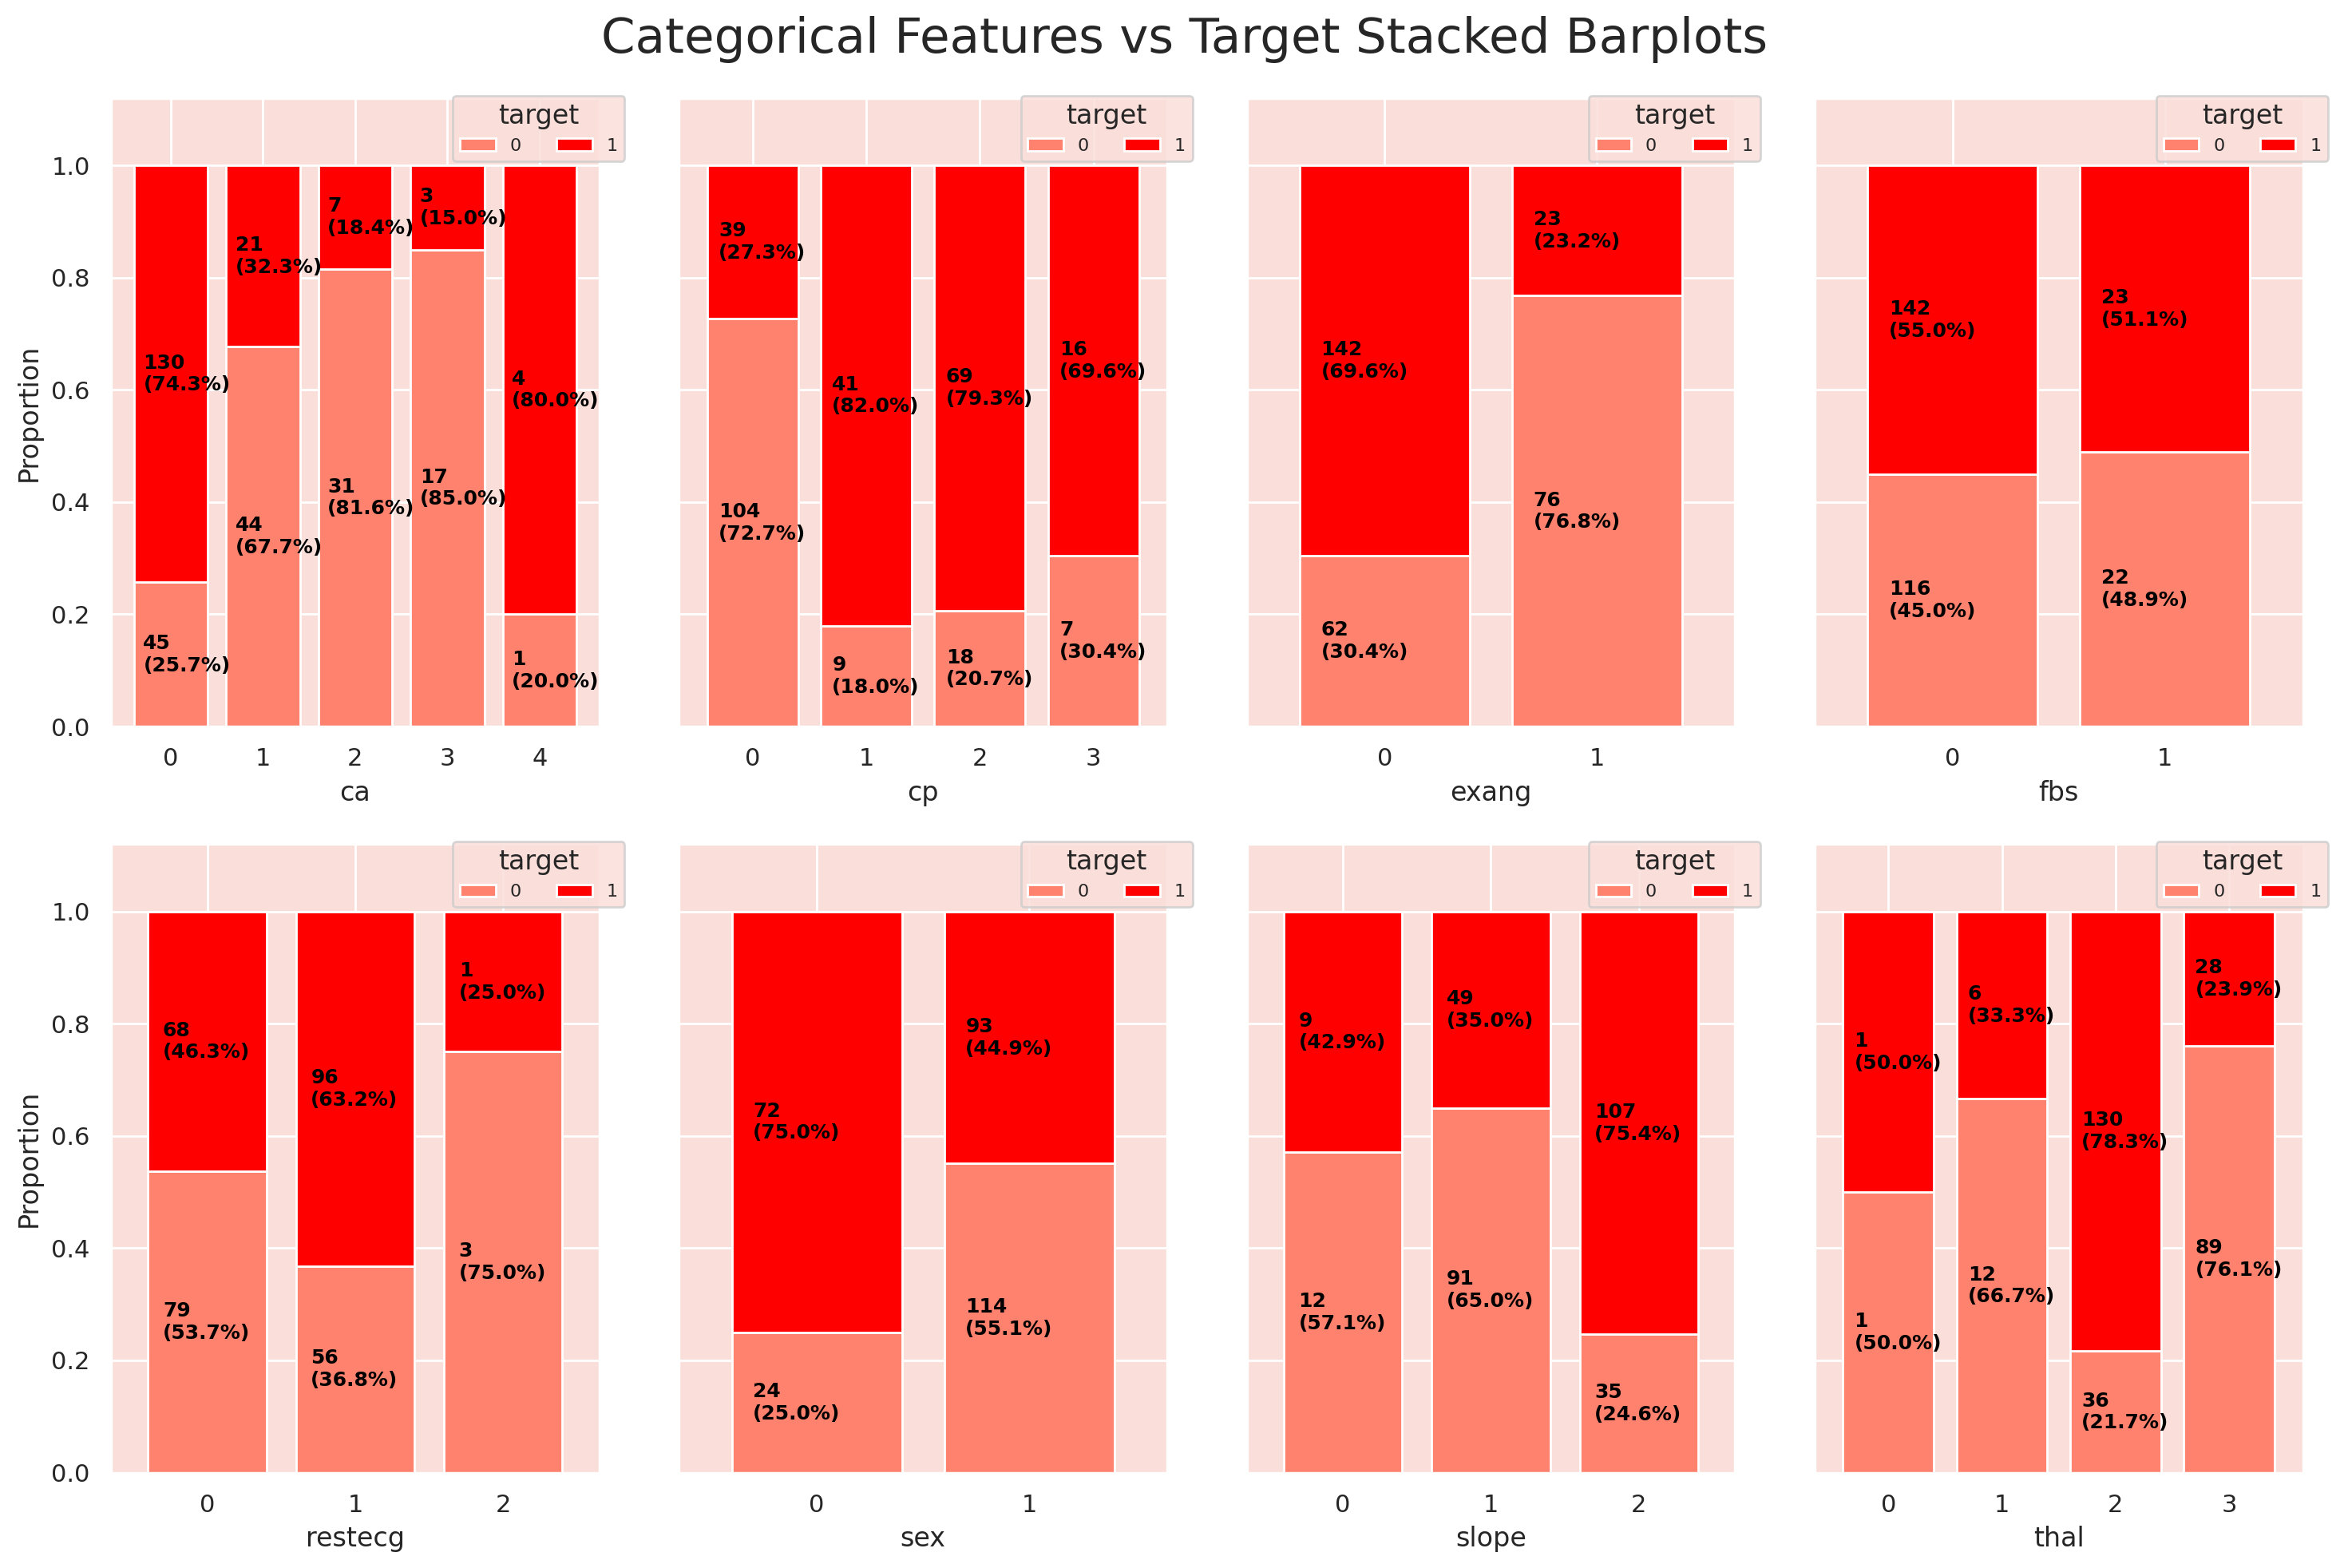

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

for i, col in enumerate(categorical_features):

    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])

    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(
        index=df[col],
        columns=df['target'],
        normalize='index'
    )

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])

    # Plot stacked bar charts
    x, y = i // 4, i % 4
    cross_tab_prop.plot(
        kind='bar',
        ax=ax[x, y],
        stacked=True,
        width=0.8,
        colormap=cmp,
        legend=False,
        ylabel='Proportion',
        sharey=True
    )

    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate(cross_tab.index.values):
        for (proportion, count, y_location) in zip(
            cross_tab_prop.loc[val],
            cross_tab.loc[val],
            cross_tab_prop.loc[val].cumsum()
        ):
            ax[x, y].text(
                x=idx - 0.3,
                y=(y_location - proportion) + (proportion / 2) - 0.03,
                s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                color='black',
                fontsize=9,
                fontweight='bold'
            )

    # Add legend
    ax[x, y].legend(title='target', loc=(0.7, 0.9), fontsize=8, ncol=2)

    # Set y limit
    ax[x, y].set_ylim([0, 1.12])

    # Rotate xticks
    ax[x, y].set_xticklabels(ax[x, y].get_xticklabels(), rotation=0)

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()
plt.show()

In [ ]:
#Checking for missing values
print(df.isnull().sum())


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [ ]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [ ]:
q1 = df[continuous_features].quantile(0.25)
q3 = df[continuous_features].quantile(0.75)
iqr = q3 - q1
outliers_count_specified = ((df[continuous_features] < (q1 - 1.5 * iqr)) | (df[continuous_features] > (q3 + 1.5 * iqr))).sum()
print(outliers_count_specified)


age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64


In [ ]:
#Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

#Convert the rest of the categorical variables that dont need one-hot encoding
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype('int')
df_encoded.dtypes

,0
age,int64
sex,int64
trestbps,int64
chol,int64
fbs,int64
thalach,int64
exang,int64
oldpeak,float64
slope,int64
ca,int64


In [ ]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False


In [ ]:
#Define features (X) and output (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [ ]:
#Adding a small constant to 'oldpeak' to avoid zero values for Box-Cox transformation
X_train['oldpeak'] = df_encoded['oldpeak'] + 0.01
X_test['oldpeak'] = df_encoded['oldpeak'] + 0.01

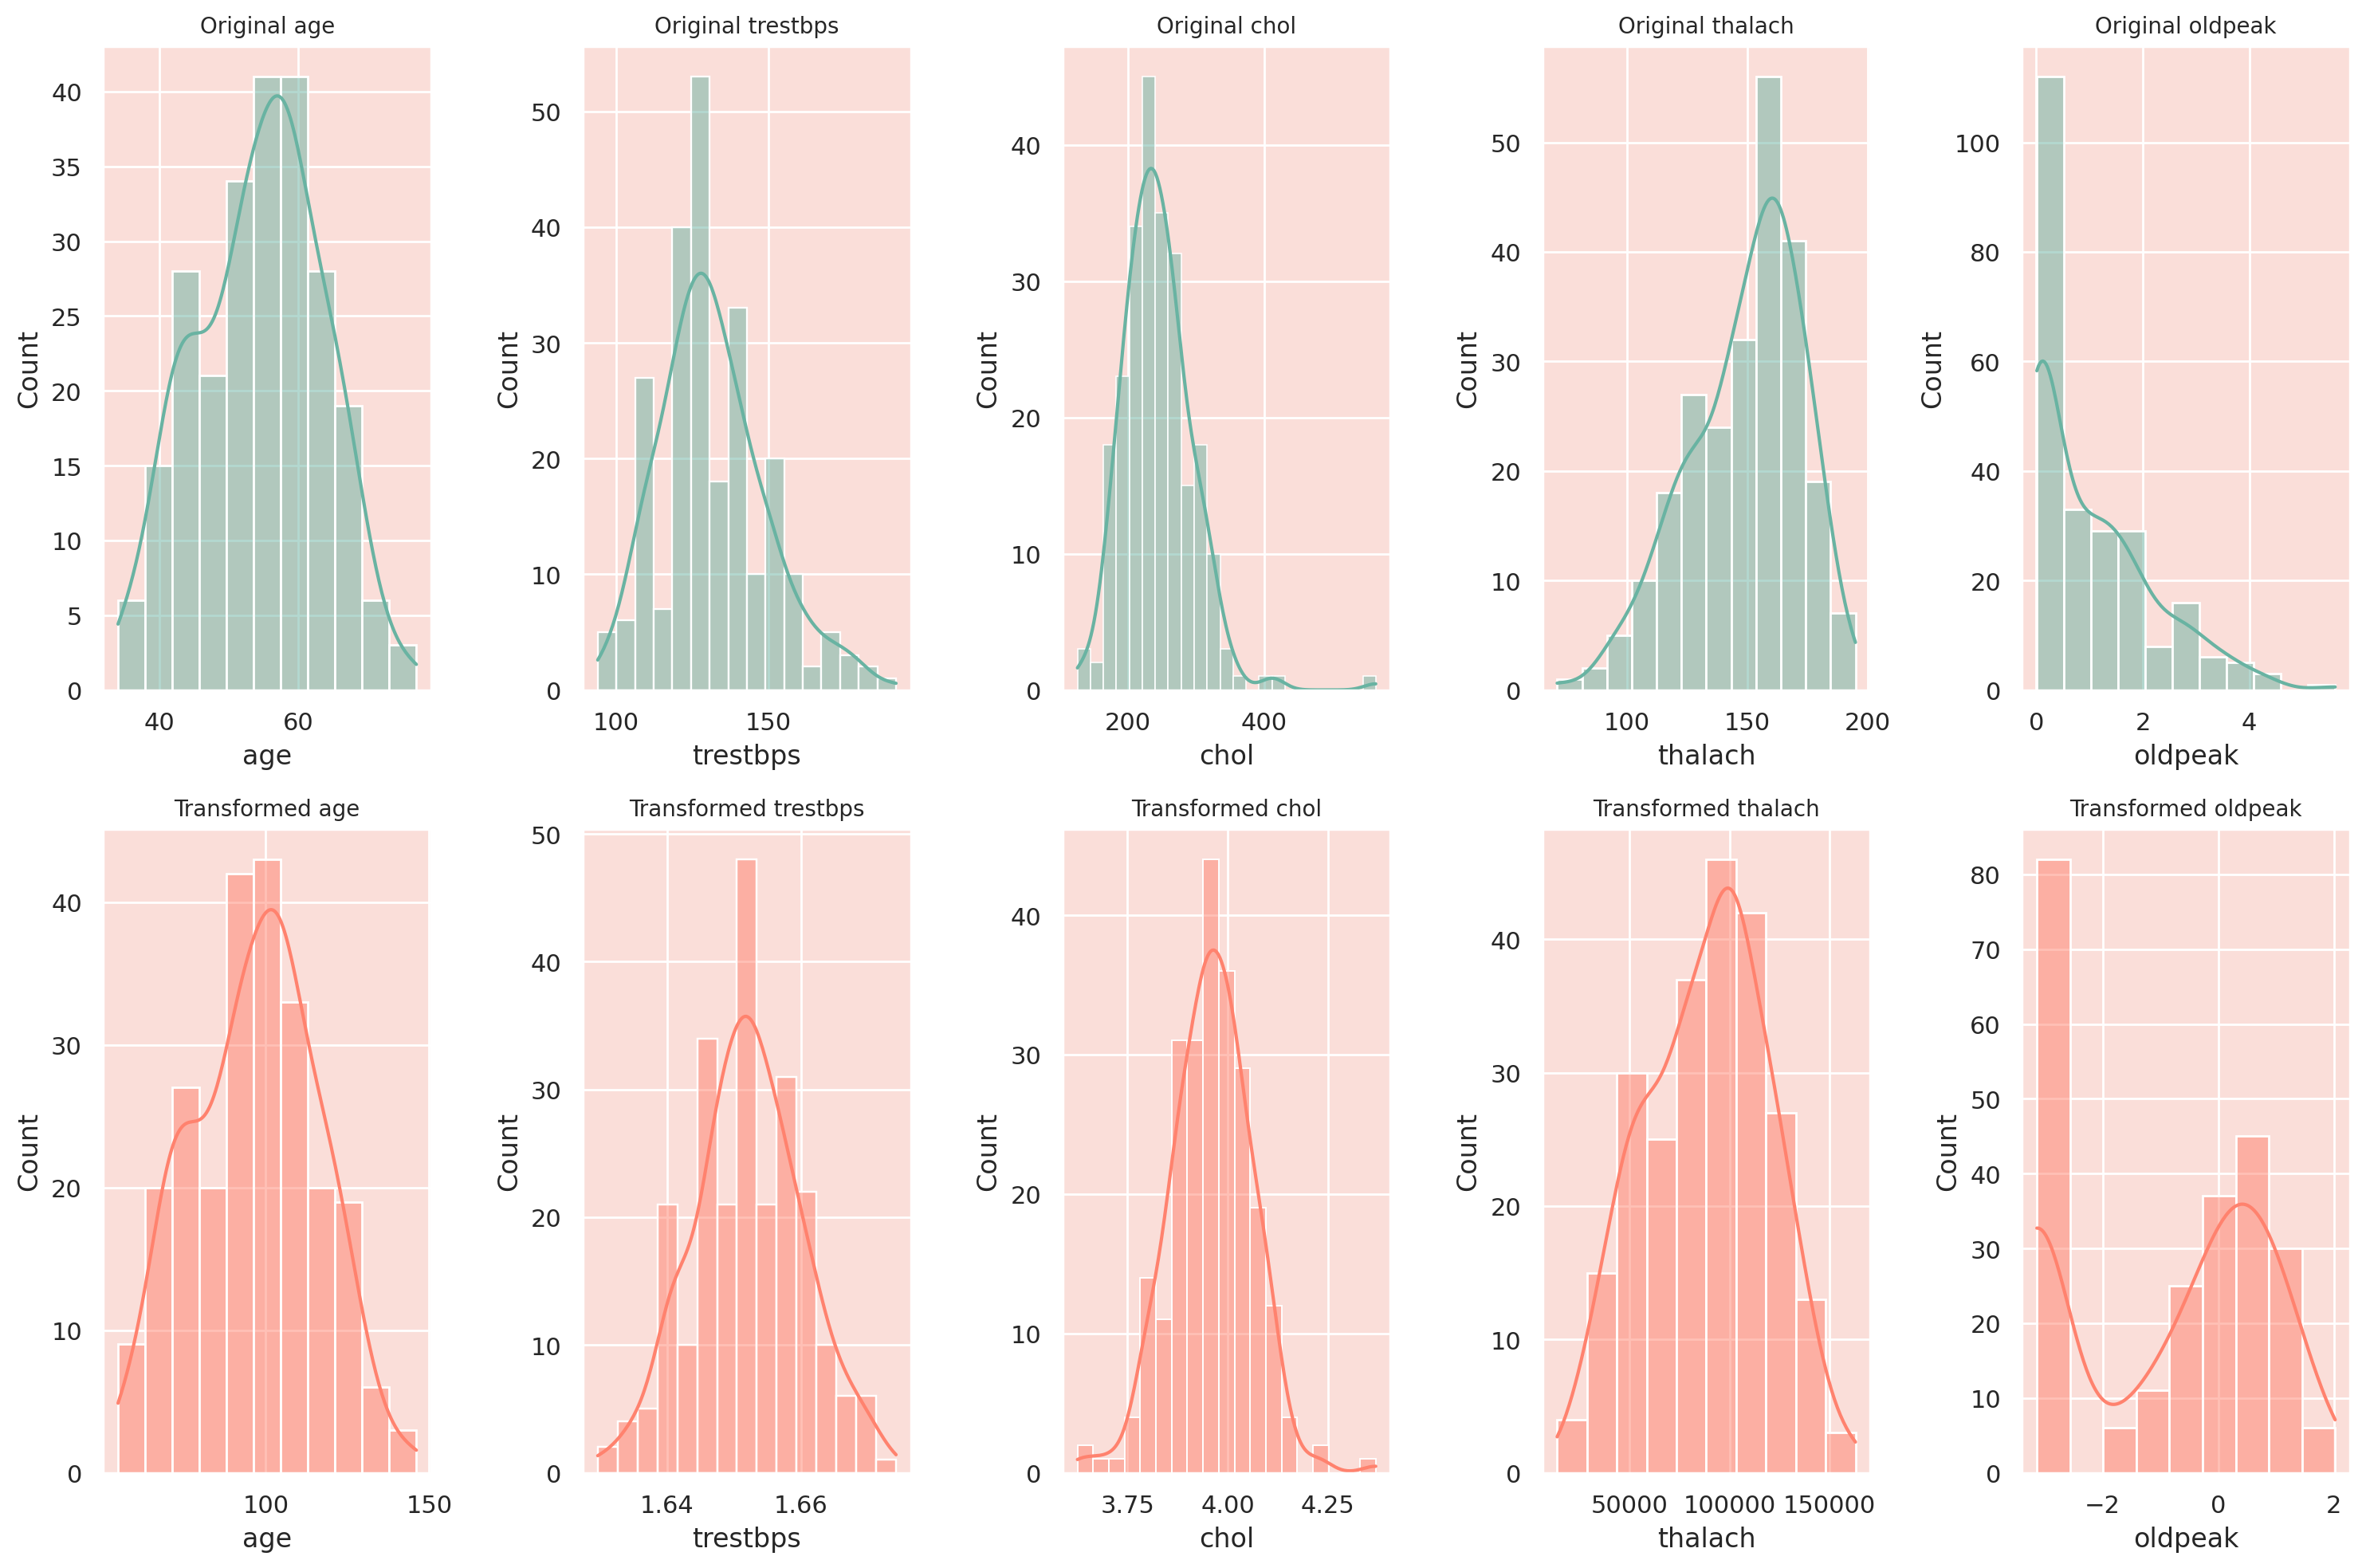

In [ ]:
#Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 5, figsize=(15, 10))

#Original distribution
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0, i], color='#69b3a2').set_title(f'Original {col}', fontsize=10)

lambdas =  {}

for i, col in enumerate(continuous_features):
  if X_train[col].min() > 0:
    X_train[col], lambdas[col] = boxcox(X_train[col])
    #Applying the same lamda to test data
    X_test[col] = boxcox(X_test[col], lmbda=lambdas[col])
    sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='#ff826e').set_title(f'Transformed {col}', fontsize=10)
  else:
    sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col}(Not found)')

fig.tight_layout()
plt.show()


In [ ]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,99.775363,1,1.652121,4.044511,1,34193.227632,1,0.497139,0,0,False,False,False,False,False,False,False,True
191,104.060287,1,1.651135,3.909224,0,61564.640490,1,0.852082,1,3,False,False,False,False,False,False,False,True
15,87.096593,0,1.646937,3.916243,0,97354.894861,0,0.497139,1,0,False,True,False,True,False,False,True,False
224,95.519188,1,1.641028,3.960431,0,55975.891019,1,1.134981,1,1,False,False,False,True,False,False,False,True
250,89.190732,1,1.656716,4.069855,0,51729.486474,1,1.639507,1,3,False,False,False,True,False,False,False,True


In [ ]:

def tune_clf_hyperparameters(
    clf,
    param_grid,
    X_train,
    y_train,
    scoring='recall',
    n_splits=3
):
    # Create the cross-validation object using StratifiedKFold
    # to ensure class distribution is the same across all folds
    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=0
    )

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    # Fit the GridSearchCV
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_

    # Return best estimator and best hyperparameters
    return clf_grid.best_estimator_, best_hyperparameters

In [ ]:
dt_base = DecisionTreeClassifier(random_state=0)

In [ ]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train,
                            scoring='recall', n_splits=3):

    # Create the cross-validation object using StratifiedKFold
    # to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=0
    )

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(
        clf,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_

    # Return the best fitted model and hyperparameters
    return clf_grid.best_estimator_, best_hyperparameters

In [ ]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [ ]:
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [ ]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.78      0.77      0.78       132

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242



In [ ]:
#Evaluate the optimized model on the train data
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



In [ ]:
def evaluate_model(model, X_test, Y_test, model_name):
    '''Evaluate the performance of a trained model on test data using various metrics'''
    #Make prediction
    y_pred = model.predict(X_test)

    #Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }

    # Convert dictionary to dataframe
    df = pd.DataFrame(metrics, index=[model_name]).round(2)

    return df

In [ ]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'Decision Tree')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
Decision Tree,0.8,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79


In [ ]:
rf_base = RandomForestClassifier(random_state=0)

In [ ]:
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}


In [ ]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(
    rf_base,
    param_grid_rf,
    X_train,
    y_train
)

print('RF Optimal Hyperparameters:\n', best_rf_hyperparams)


RF Optimal Hyperparameters:
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}


In [ ]:
print(classification_report(y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       110
           1       0.83      0.87      0.85       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



In [ ]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'Random Forest')
rf_evaluation

In [ ]:
# Define the base KNN model and set up the pipeline with scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


In [ ]:
# Hyperparameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

In [ ]:
# Hyperparameter tuning for KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(
    knn_pipeline, knn_param_grid, X_train, y_train
)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

In [ ]:
print(classification_report(y_test, best_knn.predict(X_test)))

In [ ]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

In [ ]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])


In [ ]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],
    'svm__degree': [2, 3, 4]
}

In [ ]:
#Call the function for hyperparameter tuning
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train, scoring='recall')
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

In [ ]:
print(classfication_report(y_train, best_svm.predict(X_train)))

In [ ]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

In [ ]:
# Concatenate the dataframes
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)

# Sort by recall_1
results = results.sort_values(by='recall_1', ascending=False).round(2)
results


In [ ]:
# Sort values based on 'recall_1'
results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.barh(results.index, recall_1_scores, color='red')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f'{value:.2f}', ha='left', va='center',
            fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center',
            fontweight='bold', color='white', fontsize=25)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0, 1.2])

# Add title and xlabel
plt.title("Recall for Positive Class across Models", fontweight='bold', fontsize=22)
plt.xlabel("Recall Value", fontsize=16)
plt.show()
